In [1]:
!pip install gymnasium
!pip install pygame

# Carga y exploración de un entorno de Gymnasium

In [20]:
import gymnasium as gym
import numpy as np
import time
from IPython.display import clear_output, display, HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed
import imageio
from IPython.display import HTML

SEED = 42

# -------------------- VISUALIZACIÓN DE RESULTADOS --------------------

def graficar_recompensas(agente):
    """Grafica la recompensa media acumulada por episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.stats)
    plt.title('Recompensa media acumulada')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa media')
    plt.grid(True)
    plt.show()

def graficar_longitud_episodios(agente):
    """Grafica la longitud de cada episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.episode_lengths)
    plt.title("Longitud de episodios")
    plt.xlabel("Episodio")
    plt.ylabel("Pasos")
    plt.grid(True)
    plt.show()

def mostrar_resultados_agente_continuo(agente):
    """Muestra gráficos de rendimiento en entornos continuos."""
    graficar_recompensas(agente)
    graficar_longitud_episodios(agente)

# -------------------- EJECUCIÓN DE UN EPISODIO --------------------

def ejecutar_episodio_y_mostrar(agente, render=False):
    """Ejecuta un episodio con la política aprendida y muestra la evolución de la posición."""
    env = agente.env
    state, _ = env.reset()

    random.seed(SEED)
    np.random.seed(SEED)
    
    done = False
    total_reward = 0
    posiciones = []

    while not done:
        if render:
            env.render()
        posiciones.append(state[0])  # Guardamos la posición del coche
        action = agente._seleccionar_accion_rbf(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    env.close()
    
    # Mostrar gráfico de posiciones
    plt.figure(figsize=(6, 3))
    plt.plot(posiciones)
    plt.title("Evolución de la posición del coche")
    plt.xlabel("Paso del episodio")
    plt.ylabel("Posición")
    plt.grid(True)
    plt.show()
    
    print(f"Recompensa total obtenida: {total_reward:.2f}")

# -------------------- VISUALIZACIÓN DE LA POLÍTICA EN EL ESPACIO CONTINUO --------------------

def visualizar_politica_aprendida(agente, resolution=50):
    """Visualiza la política aprendida en el espacio de estados continuo."""
    x = np.linspace(agente.low[0], agente.high[0], resolution)  # posición
    y = np.linspace(agente.low[1], agente.high[1], resolution)  # velocidad
    xx, yy = np.meshgrid(x, y)
    
    policy_map = np.zeros_like(xx)

    for i in range(resolution):
        for j in range(resolution):
            state = np.array([xx[i, j], yy[i, j]])
            policy_map[i, j] = agente._seleccionar_accion_rbf(state)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, policy_map, levels=agente.nA, cmap="coolwarm", alpha=0.8)
    cbar = plt.colorbar(ticks=range(agente.nA))
    cbar.ax.set_yticklabels([f"A{a}" for a in range(agente.nA)])
    plt.xlabel("Posición")
    plt.ylabel("Velocidad")
    plt.title("Política aprendida (acción elegida en cada punto)")
    plt.grid(True)
    plt.show()

# Objeto AgenteSARSA-SemiGradiente con RBF

In [3]:
import numpy as np
import random
from tqdm import tqdm

class RBFBasisFunctions:
    def __init__(self, low, high, num_centers=(5, 5), sigma=0.5):
        self.low = np.array(low)
        self.high = np.array(high)
        self.num_centers = np.array(num_centers)
        self.sigma = sigma

        # Normalizar límites para trabajar en [0, 1]
        self.range = self.high - self.low

        # Crear centros normalizados en grilla regular
        pos_centers = np.linspace(0, 1, num_centers[0])
        vel_centers = np.linspace(0, 1, num_centers[1])
        self.centers = np.array([[p, v] for p in pos_centers for v in vel_centers])

        self.num_features = len(self.centers)

    def normalize_state(self, state):
        return (np.array(state) - self.low) / self.range

    def get_features(self, state):
        state = self.normalize_state(state)
        features = np.exp(-np.sum((state - self.centers) ** 2, axis=1) / (2 * self.sigma ** 2))
        return features


class AgenteSARSARBF:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, decay=True, num_centers=(5, 5), sigma=0.5):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay

        self.nA = env.action_space.n
        self.low = env.observation_space.low
        self.high = env.observation_space.high

        self.rbf = RBFBasisFunctions(self.low, self.high, num_centers, sigma)
        self.d = self.rbf.num_features
        self.theta = np.zeros((self.nA, self.d))

        self.stats = []
        self.episode_lengths = []

    def _phi(self, state):
        return self.rbf.get_features(state)

    def _Q(self, state, action):
        return np.dot(self.theta[action], self._phi(state))

    def _epsilon_soft_policy_rbf(self, state):
        q_values = np.array([self._Q(state, a) for a in range(self.nA)])
        q_values = np.nan_to_num(q_values)

        policy = np.ones(self.nA) * self.epsilon / self.nA
        best_action = np.argmax(q_values)
        policy[best_action] += 1.0 - self.epsilon
        policy = np.clip(policy, 0, 1)
        return policy / policy.sum() if policy.sum() > 0 else np.ones(self.nA) / self.nA

    def _seleccionar_accion_rbf(self, state):
        policy = self._epsilon_soft_policy_rbf(state)
        return np.random.choice(np.arange(self.nA), p=policy)

    def entrenar(self, num_episodes=5000, mostrar_barra=True, seed=42):
        random.seed(seed)
        np.random.seed(seed)
        acumulador_recompensas = 0.0

        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            if self.decay:
                self.epsilon = max(0.05, 1000.0 / (t + 1))

            state, _ = self.env.reset()
            action = self._seleccionar_accion_rbf(state)
            done = False
            total_reward = 0
            pasos = 0

            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_action = self._seleccionar_accion_rbf(next_state)

                phi = self._phi(state)
                q_current = self._Q(state, action)
                q_next = self._Q(next_state, next_action) if not done else 0.0
                delta = reward + self.gamma * q_next - q_current

                if not np.isnan(delta) and not np.isinf(delta):
                    self.theta[action] += self.alpha * delta * phi
                    self.theta[action] = np.clip(self.theta[action], -1e3, 1e3)

                state = next_state
                action = next_action
                total_reward += reward
                pasos += 1

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))

In [30]:
def evaluar_configuracion(params, env_name="MountainCar-v0"):
    alpha, gamma, epsilon, decay, num_centers, sigma = params
    env = gym.make(env_name)
    agente = AgenteSARSARBF(
        env,
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon,
        decay=decay,
        num_centers=num_centers,
        sigma=sigma
    )
    agente.entrenar(num_episodes=20000, mostrar_barra=False)
    recompensa_final = np.mean(agente.stats[-100:])  # Media últimos 100 episodios
    return (alpha, gamma, epsilon, decay, num_centers, sigma, recompensa_final)

def random_search_rbf(env_name="MountainCar-v0", n_configs=100, seed=42):
    # Espacios de búsqueda
    alphas = [0.01, 0.05, 0.1]
    gammas = np.linspace(0.8, 1.0, 5)
    epsilons = np.linspace(0.1, 1.0, 5)
    num_centers_list = [(5, 5), (7, 7), (9, 9)]
    sigmas = [0.2, 0.5, 0.7]
    decays = [True, False]

    # Combinaciones posibles y aleatorias
    combinaciones = list(product(alphas, gammas, epsilons, decays, num_centers_list, sigmas))
    np.random.seed(seed)
    seleccionadas = np.random.choice(len(combinaciones), size=min(n_configs, len(combinaciones)), replace=False)
    combinaciones_random = [combinaciones[i] for i in seleccionadas]

    mejor_config = None
    mejor_recompensa = -float("inf")
    resultados = []

    print("🔍 Ejecutando búsqueda paralela de hiperparámetros (SARSA-RBF)...\n")

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(evaluar_configuracion, combo, env_name) for combo in combinaciones_random]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Progreso"):
            alpha, gamma, epsilon, decay, num_centers, sigma, recompensa = future.result()
            resultados.append((alpha, gamma, epsilon, decay, num_centers, sigma, recompensa))

            if recompensa > mejor_recompensa:
                mejor_recompensa = recompensa
                mejor_config = (alpha, gamma, epsilon, decay, num_centers, sigma)

    print("\n✅ Mejor configuración encontrada:")
    print(f" α = {mejor_config[0]}, γ = {mejor_config[1]}, ε = {mejor_config[2]}, decay = {mejor_config[3]}")
    print(f" num_centers = {mejor_config[4]}, sigma = {mejor_config[5]}")
    print(f" → Recompensa media final: {mejor_recompensa:.4f}")

In [31]:
random_search_rbf()

🔍 Ejecutando búsqueda paralela de hiperparámetros (SARSA-RBF)...



Progreso: 100%|████████████████████████████████████████████████████████████████████| 100/100 [4:24:01<00:00, 158.41s/it]


✅ Mejor configuración encontrada:
 α = 0.01, γ = 1.0, ε = 1.0, decay = True
 num_centers = (9, 9), sigma = 0.2
 → Recompensa media final: -147.9385


In [32]:
# Ejecución de ejemplo
env = gym.make("MountainCar-v0")
env.reset(seed=SEED)
agente = AgenteSARSARBF(env, alpha=0.01, gamma=1.0, epsilon=1.0, num_centers=(9, 9), sigma=0.2, decay=True)
agente.entrenar(num_episodes=50000)

100%|█████████████████████████████████████████████████████████████████████████████| 50000/50000 [32:22<00:00, 25.74it/s]


array([[-24.58561646, -16.65761545,  -8.38076872,  -7.40999906,
         -3.22056235,  -3.09738338, -17.46633008, -26.29232871,
        -17.25638729, -20.37275931,  14.73009257,  27.15950931,
          4.84769372,   7.4547004 ,  33.05333727,  26.71295955,
          4.14827028,   1.16220065, -29.76948513,  18.25445893,
         19.10124191, -40.50278912, -50.61543967,  -2.39774794,
         13.59603731,   6.18323766,  16.52061473, -28.00007678,
         20.24329598,  12.98936695, -54.40794266, -66.94066969,
        -31.4322411 , -29.99793464, -22.86576568,  19.30383349,
        -19.81070342,  14.79914557,  12.51108311, -10.84006269,
         11.3793133 ,  20.32312495, -27.7619142 , -32.89817633,
         24.39449053, -18.5471047 ,  -4.27833702,  -3.9556229 ,
          7.5154394 ,  49.22268177,  43.96263315, -15.75006041,
        -19.69109557,  34.25236356, -13.14001279,  -8.57912115,
        -13.57041512, -16.12840905,  -4.96384454, -11.95500102,
        -30.15255142,  -8.3365603 ,  33.

# Resultados de agente SARSA SemiGradiente con RBF

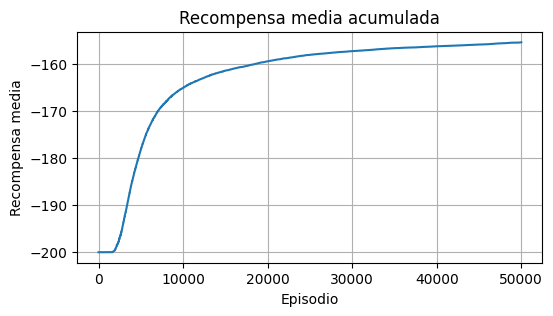

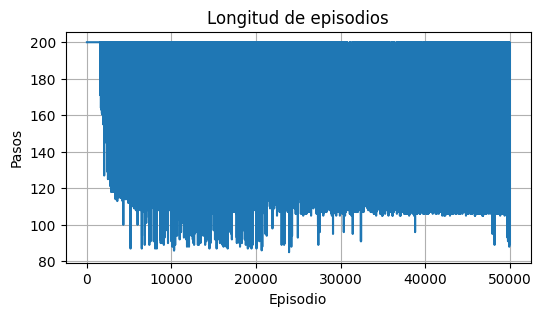

In [33]:
mostrar_resultados_agente_continuo(agente)

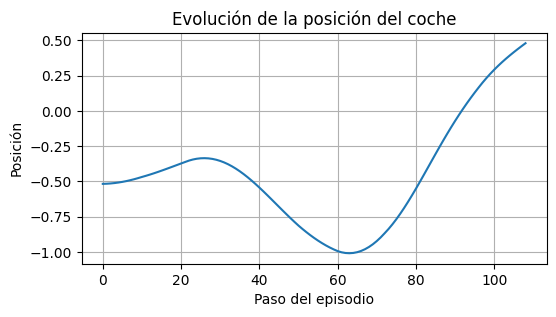

Recompensa total obtenida: -109.00


In [34]:
ejecutar_episodio_y_mostrar(agente)

In [35]:
def grabar_video_agente(agente, nombre_archivo="video_mountaincar.gif", fps=30):
    """
    Ejecuta un episodio con la política aprendida y guarda un video del entorno.
    """
    # Crear entorno con renderizado de imágenes
    env = gym.make("MountainCar-v0", render_mode="rgb_array")
    env.reset(seed=SEED)

    random.seed(SEED)
    np.random.seed(SEED)
    
    state, _ = env.reset()
    done = False
    total_reward = 0
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)

        # Acción greedy
        q_values = [agente._Q(state, a) for a in range(agente.nA)]
        action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated
        state = next_state

        if done:
            break

    env.close()

    print(f"Número total de frames: {len(frames)}")
    # Guardar el video como GIF
    imageio.mimsave(nombre_archivo, frames, fps=fps, loop=0)
    print(f"🎥 Vídeo guardado en: {nombre_archivo}")
    print(f"🏁 Recompensa total obtenida: {total_reward:.2f}")

In [36]:
nombre_archivo = "video_mountaincar_rbf.gif"

grabar_video_agente(agente, nombre_archivo=nombre_archivo)

HTML(f"""
<img src="{nombre_archivo}" style="width: 600px;" loop>
""")

Número total de frames: 107
🎥 Vídeo guardado en: video_mountaincar_rbf.gif
🏁 Recompensa total obtenida: -107.00
